In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

'''
Hyper-parameters Settings
'''
HAMPEL_WINDOW_SIZE = 21
HAMPEL_THRESHOLD = 1
HAMPEL_IMPUTATION = True

'''
Path Settings
'''
CONFIGURATION_FILE_PATH = "./data/train/data_config.csv"
DATASET_PATH = "./data/train/"

'''
Program Configurations
'''
COP_OUTPUT_SAVE_IMAGE = False
COP_OUTPUT_SAVE_CSV = True
LOADCELL_OUTPUT_SAVE_IMAGE = False
LOADCELL_OUTPUT_SAVE_CSV = True
FSR_SCALEUP_OUTPUT_SAVE_IMAGE = True
FSR_SCALEUP_COMPARE_SAVE_IMAGE = False
DYNAMIC_FSR_SCALEUP = True


'''
Figure Settings
'''
pd.set_option('display.width', 200) # for display width

print("done.")

done.


In [2]:

'''
1. Read Configurration File (only xls)
'''
data_config = pd.read_csv(CONFIGURATION_FILE_PATH, header=0, index_col=0)
print("Configuration Dataframe dimension: ", data_config.shape)


Configuration Dataframe dimension:  (50, 12)


In [3]:
'''
2. Read all FSR matrix data and Seat sensor data
'''
fsr_dataframe = {}
seat_dataframe = {}

for idx in data_config.index:
    fsr_filepath = DATASET_PATH+data_config.loc[idx, "fsr_matrix_1d_datafile"] # set FSR matrix data filepath
    seat_filepath = DATASET_PATH+data_config.loc[idx, "seat_datafile"] # set Seat data filepath
    print(idx, ") read data files : ", fsr_filepath, ",", seat_filepath)

    fsr_dataframe[idx] = pd.read_csv(fsr_filepath, header=0, index_col=False).iloc[:,0:162] # read FSR matrix data file
    seat_dataframe[idx] = pd.read_csv(seat_filepath, header=0, index_col=False) # read Seat data file

    # clear unnecessary columns
    del seat_dataframe[idx]['Measurement time'] # remove unnecessary column
    del fsr_dataframe[idx]['Measurement Time (sec)'] # remove unnecessary column
print("done.")

1 ) read data files :  ./data/train/20210303T160024-1dm.csv , ./data/train/data_01m.csv
2 ) read data files :  ./data/train/20210310T104529-1dm.csv , ./data/train/data_02m.csv
3 ) read data files :  ./data/train/20210310T110616-1dm.csv , ./data/train/data_03m.csv
4 ) read data files :  ./data/train/20210318T170103-1dm.csv , ./data/train/data_04m.csv
5 ) read data files :  ./data/train/20210310T153307-1dm.csv , ./data/train/data_05m.csv
6 ) read data files :  ./data/train/20210310T154900-1dm.csv , ./data/train/data_06m.csv
7 ) read data files :  ./data/train/20210311T131751-1dm.csv , ./data/train/data_07m.csv
8 ) read data files :  ./data/train/20210311T134516-1dm.csv , ./data/train/data_08m.csv
9 ) read data files :  ./data/train/20210311T150952-1dm.csv , ./data/train/data_09m.csv
10 ) read data files :  ./data/train/20210311T153746-1dm.csv , ./data/train/data_10m.csv
11 ) read data files :  ./data/train/20210311T154809-1dm.csv , ./data/train/data_11m.csv
12 ) read data files :  ./data

In [14]:
'''
3. Preprocessing : Seat Loadcell data filtering for Observation of CoP(Center of Pressure) movement
   - @brief some impulsive noise is included in the data of the loadcells attatched to the bottom of the seat frame. so it should be reduced with noise filtering.
   - @method : hampel filter
'''
from hampel import hampel
import os.path

seat_loadcell_dataframe = {} # finally filtered loadcell data

if LOADCELL_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/seat_loadcell_filtering") # create diretory
    except FileExistsError:
        pass

if LOADCELL_OUTPUT_SAVE_CSV==True:
    try:
        os.mkdir("./csv/seat_loadcell_filtering") # create directory
    except FileExistsError:
        pass

for idx in data_config.index:
    seat_loadcell = seat_dataframe[idx].loc[:,["Seat L1", "Seat L2", "Seat L3", "Seat L4"]]

    # extract raw data
    seat_loadcell_raw = pd.DataFrame()
    seat_loadcell_raw["Seat L1"] = seat_loadcell["Seat L1"]
    seat_loadcell_raw["Seat L2"] = seat_loadcell["Seat L2"]
    seat_loadcell_raw["Seat L3"] = seat_loadcell["Seat L3"]
    seat_loadcell_raw["Seat L4"] = seat_loadcell["Seat L4"]

    # apply hampel filter with appropriate filter parameters from the raw data
    seat_loadcell_filtered = pd.DataFrame()
    seat_loadcell_filtered["Seat L1"] = hampel(seat_loadcell_raw["Seat L1"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L2"] = hampel(seat_loadcell_raw["Seat L2"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L3"] = hampel(seat_loadcell_raw["Seat L3"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)
    seat_loadcell_filtered["Seat L4"] = hampel(seat_loadcell_raw["Seat L4"], window_size=HAMPEL_WINDOW_SIZE, n=HAMPEL_THRESHOLD, imputation=HAMPEL_IMPUTATION)

    # add sum column for CoP movement
    seat_loadcell_filtered["sum"]=seat_loadcell_filtered.sum(axis=1) # adding sum column

    if LOADCELL_OUTPUT_SAVE_CSV==True:
        result_csv_filepath = "./csv/seat_loadcell_filtering/seat_loadcell_filtering_{}.csv".format(idx)
        if os.path.isfile(result_csv_filepath)==False:
            seat_loadcell_filtered.to_csv(result_csv_filepath, index=False)
            print("saved {}".format(result_csv_filepath))

    seat_loadcell_dataframe[idx] = seat_loadcell_filtered # adding results

    '''
    Plotting all raw seat loadcell data
    '''
    # save to image file
    if LOADCELL_OUTPUT_SAVE_IMAGE==True:
        result_image_filepath = "./images/seat_loadcell_filtering/seat_loadcell_filtering_{}.png".format(idx)

        if os.path.isfile(result_image_filepath)==False:
            fig = plt.figure(figsize=(25,5), constrained_layout=True)
            plt.plot(seat_loadcell_raw["Seat L1"], 'b', label='Raw L1')
            plt.plot(seat_loadcell_raw["Seat L2"], 'b', label='Raw L2')
            plt.plot(seat_loadcell_raw["Seat L3"], 'b', label='Raw L3')
            plt.plot(seat_loadcell_raw["Seat L4"], 'b', label='Raw L4')

            # Plotting all filtered seat loadcell data
            plt.plot(seat_loadcell_filtered["Seat L1"], 'r', label='filtered L1')
            plt.plot(seat_loadcell_filtered["Seat L2"], 'r', label='filtered L2')
            plt.plot(seat_loadcell_filtered["Seat L3"], 'r', label='filtered L3')
            plt.plot(seat_loadcell_filtered["Seat L4"], 'r', label='filtered L4')

            plt.legend()
            plt.title("Seat Loadcell Data Filtering (ID : {})".format(idx), fontsize=16)
            plt.xlabel("Sequences")
            plt.ylabel("Pressure")
            plt.grid()
            
            fig.savefig(result_image_filepath)
            print("save to image : ",result_image_filepath)
        else:
            print("image is already exist : {}".format(result_image_filepath))

        plt.close(fig)
    print("data filtered : {}".format(idx))

print("done.")

data filtered : 1
data filtered : 2
data filtered : 3
data filtered : 4
data filtered : 5
data filtered : 6
data filtered : 7
data filtered : 8
data filtered : 9
data filtered : 10
data filtered : 11
data filtered : 12
data filtered : 13
data filtered : 14
data filtered : 15
data filtered : 16
data filtered : 17
data filtered : 18
data filtered : 19
data filtered : 20
data filtered : 21
data filtered : 22
data filtered : 23
data filtered : 24
data filtered : 25
data filtered : 26
data filtered : 27
data filtered : 28
data filtered : 29
data filtered : 30
data filtered : 31
data filtered : 32
data filtered : 33
data filtered : 34
data filtered : 35
data filtered : 36
data filtered : 37
data filtered : 38
data filtered : 39
data filtered : 40
data filtered : 41
data filtered : 42
data filtered : 43
data filtered : 44
data filtered : 45
data filtered : 46
data filtered : 47
data filtered : 48
data filtered : 49
data filtered : 50
done.


In [13]:
'''
3. Proceess : Movement of CoP(Center of Pressure)
   - @brief observe the center of pressure movement with filtered data
'''
import os.path

if COP_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/cop") # create diretory
    except FileExistsError:
        pass

if COP_OUTPUT_SAVE_CSV==True:
        try:
            os.mkdir("./csv/cop") # create directory
        except FileExistsError:
            pass

cop_dataframe = {}
for idx in data_config.index:
    # define loadcell relative position
    LPos = {"Seat L1":(455,366), "Seat L2":(455,0), "Seat L3":(0,0), "Seat L4":(0,366)}

    # compute center of pressure
    data = seat_loadcell_dataframe[idx]
    COPx = (data["Seat L1"]*LPos["Seat L1"][0]+data["Seat L2"]*LPos["Seat L2"][0]+data["Seat L3"]*LPos["Seat L3"][0]+data["Seat L4"]*LPos["Seat L4"][0])/data["sum"]
    COPy = (data["Seat L1"]*LPos["Seat L1"][1]+data["Seat L2"]*LPos["Seat L2"][1]+data["Seat L3"]*LPos["Seat L3"][1]+data["Seat L4"]*LPos["Seat L4"][1])/data["sum"]
    
    copdata = pd.DataFrame()
    copdata["COPx"] = COPx
    copdata["COPy"] = COPy
    cop_dataframe[idx] = copdata

    if COP_OUTPUT_SAVE_CSV==True:
        try:
            result_csv_filepath = "./csv/cop/cop_{}.csv".format(idx)
            if os.path.isfile(result_csv_filepath)==False:
                copdata.to_csv(result_csv_filepath, index=False)

        except FileExistsError:
            pass

    # save to image file
    if COP_OUTPUT_SAVE_IMAGE==True:

        result_image_filepath = "./images/cop/cop_{}.png".format(idx)
        if os.path.isfile(result_image_filepath)==False:
            # plotting figure
            fig = plt.figure(figsize=(7,5), constrained_layout=True)
            plt.xlim([0, 455])
            plt.ylim([0, 366])
            plt.plot(COPx, COPy, 'b', label='COP')
            plt.title("Movement of Center of Pressure({})".format(idx), fontsize=16)
            plt.legend()
            plt.xlabel('X Position(mm)')
            plt.ylabel('Y Position(mm)')
            plt.grid()

            
            fig.savefig(result_image_filepath)
            print("save to image : ",result_image_filepath)
            plt.close(fig)
        else:
            print("image is alreadu exist : {}".format(result_image_filepath))

print("done.")


KeyError: 1

In [6]:
'''
4. Preproceess : Data Segmentation by mtime
   - @brief     FSR matrix data and Seat data should be segmented by mtime
   - @output    segmented dataframes
'''

# output dict.
fsr_dataframe_standard_segment = {}
fsr_dataframe_relax_segment = {}
seat_loadcell_dataframe_standard_segment = {}
seat_loadcell_dataframe_relax_segment = {}

for idx in data_config.index:
    mtime = data_config.loc[idx, ['standard_s_mtime', "standard_e_mtime", "relax_s_mtime", "relax_e_mtime"]]
    
    # seat loadcell segmentation
    seat_loadcell_dataframe_standard_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    seat_loadcell_dataframe_relax_segment[idx] = seat_dataframe[idx][(seat_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (seat_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    # fsr matrix segmentation
    fsr_dataframe_standard_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.standard_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.standard_e_mtime)]
    fsr_dataframe_relax_segment[idx] = fsr_dataframe[idx][(fsr_dataframe[idx]['mtime']>=mtime.relax_s_mtime) & (fsr_dataframe[idx]['mtime']<=mtime.relax_e_mtime)]

    print("FSR Segments@Standard size : ", len(fsr_dataframe_standard_segment[idx]), ", FSR Segments@Relax size : ", len(fsr_dataframe_relax_segment[idx]))
    print("Seat Segments@Standard size : ", len(seat_loadcell_dataframe_standard_segment[idx]), ", Seat Segments@Relax size : ", len(seat_loadcell_dataframe_relax_segment[idx]))

print("done.")


FSR Segments@Standard size :  130 , FSR Segments@Relax size :  128
Seat Segments@Standard size :  237 , Seat Segments@Relax size :  232
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  130
Seat Segments@Standard size :  219 , Seat Segments@Relax size :  232
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  122
Seat Segments@Standard size :  219 , Seat Segments@Relax size :  219
FSR Segments@Standard size :  122 , FSR Segments@Relax size :  133
Seat Segments@Standard size :  220 , Seat Segments@Relax size :  239
FSR Segments@Standard size :  127 , FSR Segments@Relax size :  131
Seat Segments@Standard size :  236 , Seat Segments@Relax size :  242
FSR Segments@Standard size :  127 , FSR Segments@Relax size :  129
Seat Segments@Standard size :  229 , Seat Segments@Relax size :  233
FSR Segments@Standard size :  123 , FSR Segments@Relax size :  128
Seat Segments@Standard size :  227 , Seat Segments@Relax size :  236
FSR Segments@Standard size :  123 , FSR Segments

In [7]:
'''
4. Preproceess : Segmented FSR Matrix Data up-scaling
   - @brief raw data(16x10 dim.) build high resolution image with interpolation(super-resolution)
   - @method    catrom (Centripetal Catmull–Rom spline)
   - @output    scaled up images for all swquences
   - @note  1) saving output image may take too long time. if you already done, skip this code block.
            2) converting all data to image is not efficient. use start/end time configuration defined in data_config.csv
            3) if file is already exist, process will be skiped.
'''
import os
import os.path


if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
    try:
        os.mkdir("./images/fsr_matrix") # create diretory
    except FileExistsError:
        pass

fsr_standard_interpolated_paths = {}
fsr_relax_interpolated_paths = {}

for idx in data_config.index:
    fsr_standard_segment_1d = fsr_dataframe_standard_segment[idx].iloc[:,1:161]
    fsr_standard_segment_2d = fsr_standard_segment_1d.values.reshape(-1, 16, 10) # reshape

    fsr_relax_segment_1d = fsr_dataframe_relax_segment[idx].iloc[:,1:161]
    fsr_relax_segment_2d = fsr_relax_segment_1d.values.reshape(-1, 16, 10)

    try:
        os.mkdir("./images/fsr_matrix/{}".format(idx)) # create diretory for each id
    except FileExistsError:
        pass
    
    # @standard mode
    standard_fsr_file_list = []
    for ridx in range(fsr_standard_segment_2d.shape[0]):
        result_image_filepath = "./images/fsr_matrix/{}/standard_{}.jpg".format(idx, ridx)

        if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:
                fig = plt.figure()
                plt.axis('off')
                if DYNAMIC_FSR_SCALEUP==True:
                    plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', cmap='Greys_r')
                else:
                    plt.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='Greys_r')
                plt.savefig(result_image_filepath, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
        
        standard_fsr_file_list.append(result_image_filepath)
        print("(standard) saved output images for id {}, {}".format(idx, ridx))
        
    fsr_standard_interpolated_paths[idx] = pd.DataFrame(standard_fsr_file_list, columns=['path'])
    

    # @ relax mode
    relax_fsr_file_list = []
    for ridx in range(fsr_relax_segment_2d.shape[0]):
        result_image_filepath = "./images/fsr_matrix/{}/relax_{}.jpg".format(idx, ridx)

        if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
            if os.path.isfile(result_image_filepath)==True: # file exist
                print("{} is already exist".format(result_image_filepath))
            else:
                fig = plt.figure()
                plt.axis('off')
                if DYNAMIC_FSR_SCALEUP==True:
                    plt.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', cmap='Greys_r')
                else:
                    plt.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='Greys_r')
                plt.savefig(result_image_filepath, bbox_inches='tight', pad_inches=0)
                plt.close(fig)
        
        relax_fsr_file_list.append(result_image_filepath)
        print("(relax) saved output images for id {}, {}".format(idx, ridx))
        
    fsr_relax_interpolated_paths[idx] = pd.DataFrame(relax_fsr_file_list, columns=['path'])


    if FSR_SCALEUP_COMPARE_SAVE_IMAGE==True:
        # show compared graph between raw and upscaled data
        # @ standard mode
        for ridx in range(fsr_standard_segment_2d.shape[0]):
            fig = plt.figure(figsize=(11,6), constrained_layout=True)

            # raw matrix data plot
            fig_raw = fig.add_subplot(1,2,1)
            if DYNAMIC_FSR_SCALEUP==True:
                ax_raw = fig_raw.imshow(fsr_standard_segment_2d[ridx], interpolation='None', cmap='viridis')
                fig_raw.set_title("Raw(Dynamic) FSR Matrix Data", fontsize=16)
            else:
                ax_raw = fig_raw.imshow(fsr_standard_segment_2d[ridx], interpolation='None', vmin=0, vmax=255, cmap='viridis')
                fig_raw.set_title("Raw(Static) FSR Matrix Data", fontsize=16)
            fig_raw.set_xlabel('X position(mm)')
            fig_raw.set_ylabel('Y position(mm)')
            fig.colorbar(ax_raw)

            # interpolated matrix data plot
            fig_hr = fig.add_subplot(1,2,2)
            if DYNAMIC_FSR_SCALEUP==True:
                ax_hr = fig_hr.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', cmap='viridis')
                fig_hr.set_title("Interpolated(Dynamic) FSR Matrix Data", fontsize=16)
            else:
                ax_hr = fig_hr.imshow(fsr_standard_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='viridis')
                fig_hr.set_title("Interpolated(Static) FSR Matrix Data", fontsize=16)
            
            fig_hr.set_xlabel('X position(mm)')
            fig_hr.set_ylabel('Y position(mm)')
            fig.colorbar(ax_hr)
            
            if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
                # save to image file
                if DYNAMIC_FSR_SCALEUP==True:
                    result_image_filepath = "./images/fsr_matrix/{}/compared_standard_dynamic_{}.png".format(idx, ridx)
                else:
                    result_image_filepath = "./images/fsr_matrix/{}/compared_standard_static_{}.png".format(idx, ridx)
                fig.savefig(result_image_filepath)
                print("(standard) save to image : ",result_image_filepath)
            plt.close(fig)

        # @relax mode
        for ridx in range(fsr_relax_segment_2d.shape[0]):
            fig = plt.figure(figsize=(11,6), constrained_layout=True)

            # raw matrix data plot
            fig_raw = fig.add_subplot(1,2,1)
            if DYNAMIC_FSR_SCALEUP==True:
                ax_raw = fig_raw.imshow(fsr_relax_segment_2d[ridx], interpolation='None', cmap='viridis')
                fig_raw.set_title("Raw(Dynamic) FSR Matrix Data", fontsize=16)
            else:
                ax_raw = fig_raw.imshow(fsr_relax_segment_2d[ridx], interpolation='None', vmin=0, vmax=255, cmap='viridis')
                fig_raw.set_title("Raw(Static) FSR Matrix Data", fontsize=16)
            fig_raw.set_xlabel('X position(mm)')
            fig_raw.set_ylabel('Y position(mm)')
            fig.colorbar(ax_raw)

            # interpolated matrix data plot
            fig_hr = fig.add_subplot(1,2,2)
            if DYNAMIC_FSR_SCALEUP==True:
                ax_hr = fig_hr.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', cmap='viridis')
                fig_hr.set_title("Interpolated(Dynamic) FSR Matrix Data", fontsize=16)
            else:
                ax_hr = fig_hr.imshow(fsr_relax_segment_2d[ridx], interpolation='catrom', vmin=0, vmax=255, cmap='viridis')
                fig_hr.set_title("Interpolated(Static) FSR Matrix Data", fontsize=16)
            fig_hr.set_xlabel('X position(mm)')
            fig_hr.set_ylabel('Y position(mm)')
            fig.colorbar(ax_hr)
            
            if FSR_SCALEUP_OUTPUT_SAVE_IMAGE==True:
                # save to image file
                if DYNAMIC_FSR_SCALEUP==True:
                    result_image_filepath = "./images/fsr_matrix/{}/compared_relax_dynamic_{}.png".format(idx, ridx)
                else:
                    result_image_filepath = "./images/fsr_matrix/{}/compared_relax_static_{}.png".format(idx, ridx)
                fig.savefig(result_image_filepath)
                print("(standard) save to image : ",result_image_filepath)
            plt.close(fig)

    print("done.")
        

 output images for id 49, 78
(standard) saved output images for id 49, 79
(standard) saved output images for id 49, 80
(standard) saved output images for id 49, 81
(standard) saved output images for id 49, 82
(standard) saved output images for id 49, 83
(standard) saved output images for id 49, 84
(standard) saved output images for id 49, 85
(standard) saved output images for id 49, 86
(standard) saved output images for id 49, 87
(standard) saved output images for id 49, 88
(standard) saved output images for id 49, 89
(standard) saved output images for id 49, 90
(standard) saved output images for id 49, 91
(standard) saved output images for id 49, 92
(standard) saved output images for id 49, 93
(standard) saved output images for id 49, 94
(standard) saved output images for id 49, 95
(standard) saved output images for id 49, 96
(standard) saved output images for id 49, 97
(standard) saved output images for id 49, 98
(standard) saved output images for id 49, 99
(standard) saved output im

In [32]:
'''
<for testing>
4. Preproceess : fsr matrix image separation (left or right)
   - @brief interpolated high resolution image divide into two class(left, right leg)
   - @method    K Means Clustering
   - @output    class image
'''

from skimage import io, color

# leg-side separation (half & half)
# fsr image resolution (1132x1812)
FSR_SEPARATION_WIDTH = 566


# for idx in data_config.index:
#     print("standard file path : {}".format(fsr_standard_interpolated_paths[idx]))
#     print("relax file path : {}".format(fsr_relax_interpolated_paths[idx]))

print(fsr_standard_interpolated_paths[1])
# image = io.imread(fsr_standard_interpolated_paths[1][0])
# plt.imshow(image)
# plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [22]:
'''
<for testing>
4. Preproceess : fsr matrix image separation (left or right)
   - @brief interpolated high resolution image divide into two class(left, right leg)
   - @method    K Means Clustering
   - @output    class image
'''

from sklearn.cluster import KMeans
from skimage import io, color

# leg-side separation (half & half)
# fsr image resolution (1132x1812)
FSR_SEPARATION_WIDTH = 566


for idx in data_config.index:
    print("file path : {}".format(fsr_standard_interpolated_paths[idx]))


fsr_data = fsr_dataframe[idx].iloc[:,1:161] # extract fsr matrix data
fsr_data_3d = fsr_data.values.reshape(-1, 16, 10) # reshape the dataframes

filename = fsr_interpolated_paths[1]["path"][668]
img = io.imread(filename)
grayscale = color.rgb2gray(img)
#io.imshow(grayscale)

img_dataframe = pd.DataFrame(grayscale)
img_dataframe = img_dataframe.stack().reset_index()
img_dataframe.columns = ['x','y','v']

kmeans = KMeans(n_clusters=2)
kmeans.fit(img_dataframe)

clustered = img_dataframe.copy()
clustered['cluster'] = kmeans.labels_

print(clustered)


# selection
cluster_right = clustered[clustered['cluster'] == 1]
#cluster_right = cluster_right.loc[:,['x','y']]
#print(cluster_right)

#plt.figure(figsize=(6,6), constrained_layout=True)
#plt.scatter(cluster_right['x'], cluster_right['y'])
#plt.show()



#print(len(kmeans.labels_))

#result_by_sklearn = grayscale.copy()
#result_by_sklearn["cluster"] = kmeans.labels
#result_by_sklearn.head()


# break

# kmeans = KMeans(n_clusters=2) # k is only 2(left, right)
# kmeans.fit(fsr_data_3d[1])

# # 결과 확인
# result_by_sklearn = points.copy()
# result_by_sklearn["cluster"] = kmeans.labels_
# result_by_sklearn.head()

         x    y         v  cluster
0        0    0  0.000000        0
1        0    1  0.000000        0
2        0    2  0.000000        0
3        0    3  0.000000        0
4        0    4  0.000000        0
5        0    5  0.000000        0
6        0    6  0.000000        0
7        0    7  0.000000        0
8        0    8  0.007843        0
9        0    9  0.007843        0
10       0   10  0.007843        0
11       0   11  0.011765        0
12       0   12  0.019608        0
13       0   13  0.023529        0
14       0   14  0.031373        0
15       0   15  0.035294        0
16       0   16  0.043137        0
17       0   17  0.047059        0
18       0   18  0.054902        0
19       0   19  0.058824        0
20       0   20  0.062745        0
21       0   21  0.070588        0
22       0   22  0.078431        0
23       0   23  0.082353        0
24       0   24  0.090196        0
25       0   25  0.098039        0
26       0   26  0.109804        0
27       0   27  0.1

In [184]:
 = clustered.loc[:,['x','y','cluster']]


         x    y  cluster
0        0    0        0
1        0    1        0
2        0    2        0
3        0    3        0
4        0    4        0
...    ...  ...      ...
29290  216  130        1
29291  216  131        1
29292  216  132        1
29293  216  133        1
29294  216  134        1

[29295 rows x 3 columns]


<Figure size 1296x432 with 0 Axes>

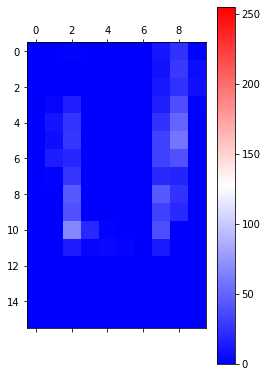

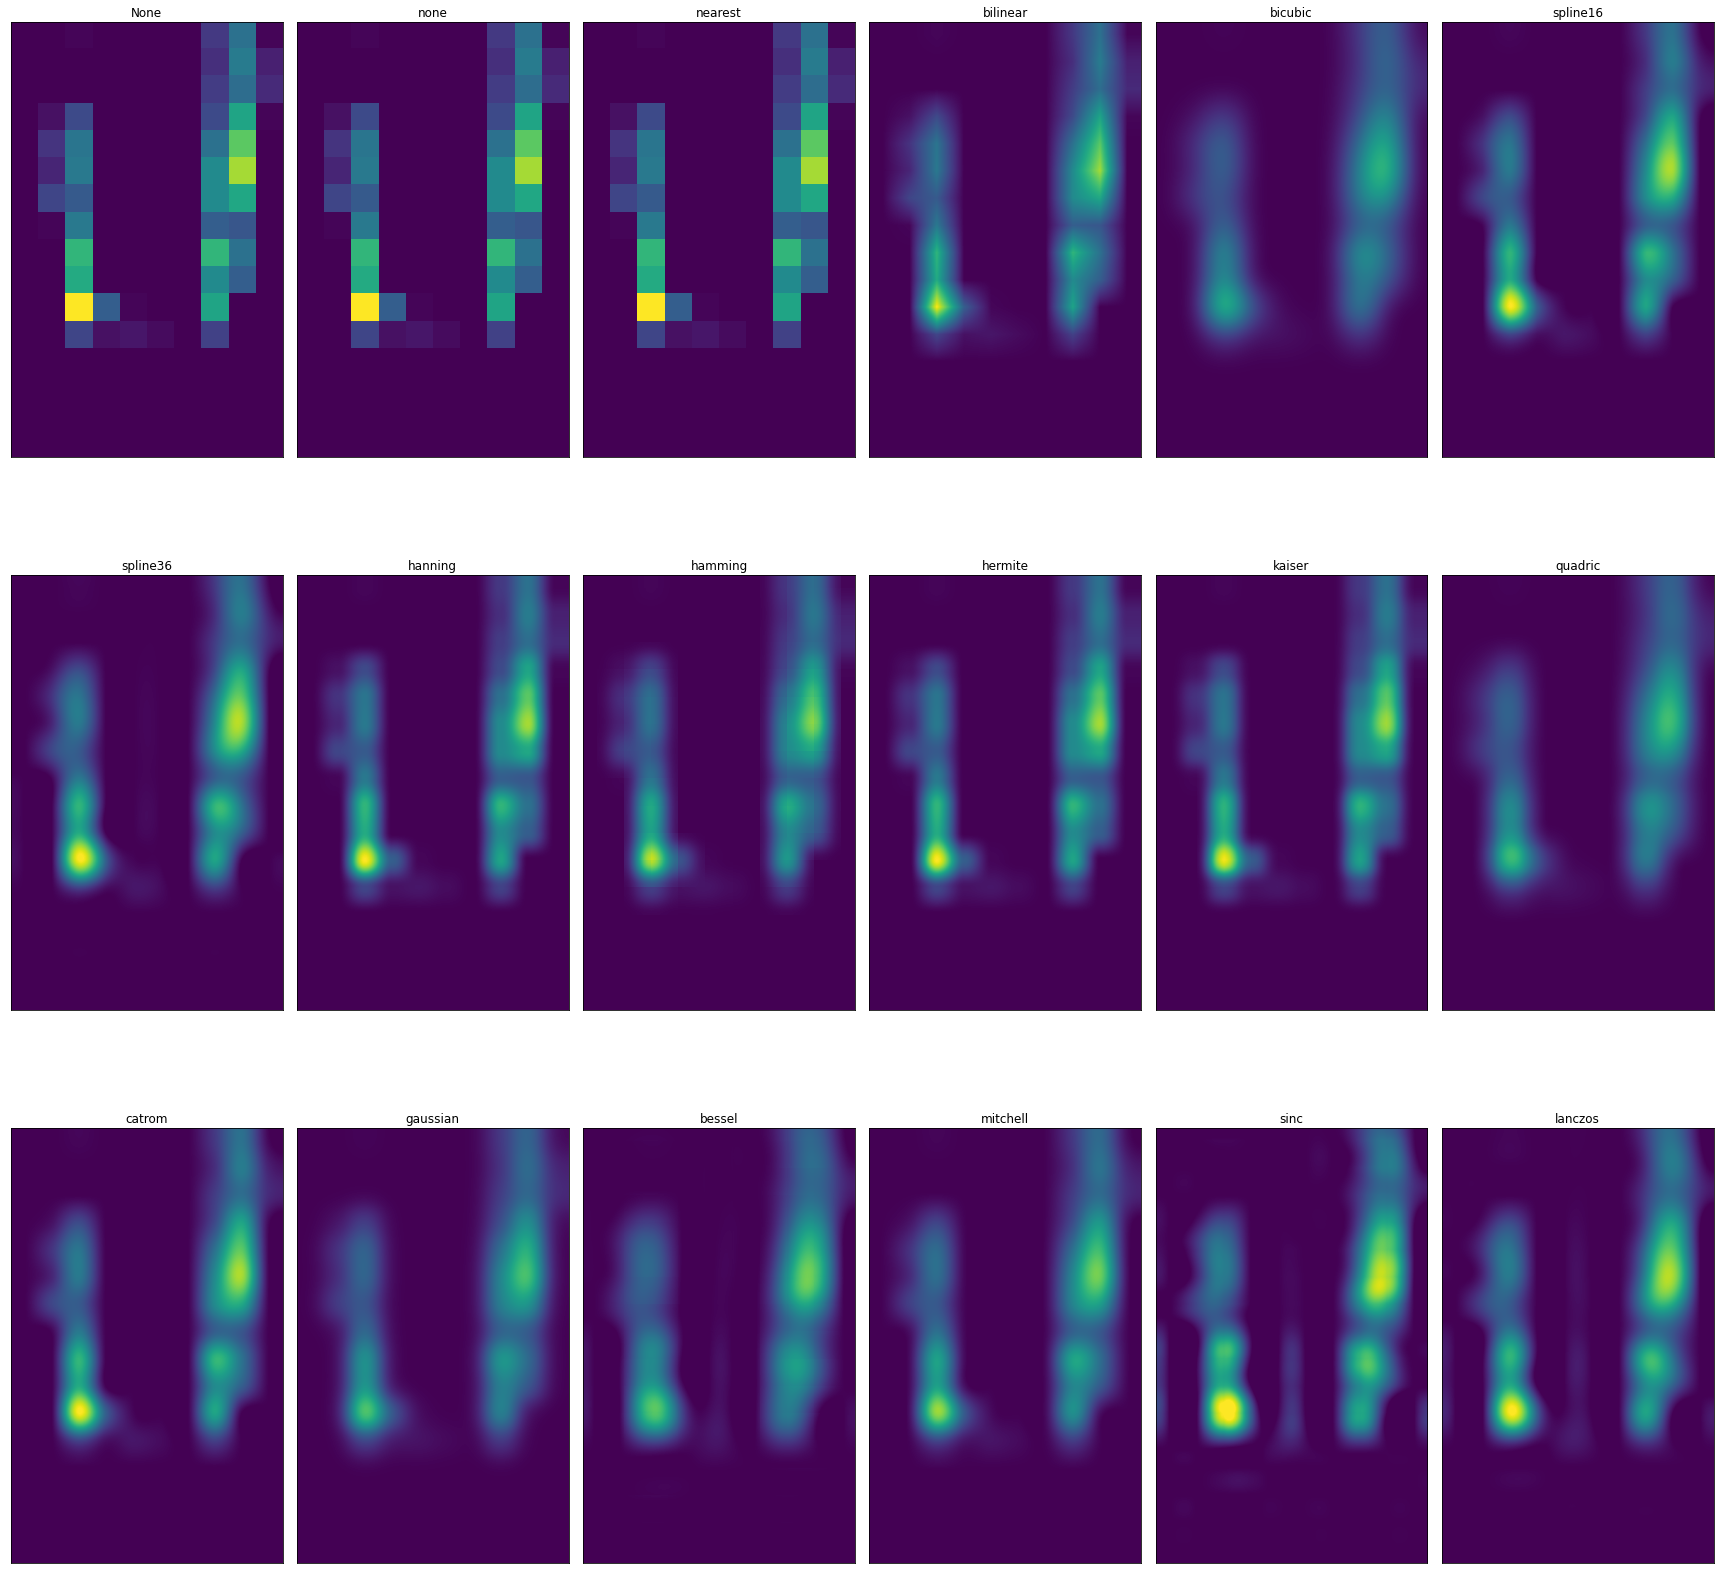

In [9]:
# FSR Matrix data

# for idx in data_config.index:
#     fsr_data = fsr_dataframe[idx].iloc[:,1:161]
#     fsr_data_3d = fsr_data.values.reshape(-1, 16, 10) #convert to 3d

#     plt.figure(figsize=(8,5), constrained_layout=True)
    

#     plt.grid()
#     plt.show()


idx = 1
fsr_data = fsr_dataframe[idx].iloc[:,1:161]
fsr_data_3d = fsr_data.values.reshape(-1, 16, 10) #convert to 3d

rindx = 684
plt.figure(figsize=(18,6), constrained_layout=True)
plt.matshow(fsr_data_3d[rindx], cmap=plt.get_cmap('bwr'))
plt.clim(0, 255)
plt.colorbar()
plt.show()

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(24, 24), subplot_kw={'xticks': [], 'yticks': []})
for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(fsr_data_3d[rindx], interpolation=interp_method, cmap='viridis')
    ax.set_title(str(interp_method))
plt.tight_layout()
plt.show()

In [5]:

# select random 5 user samples for training phase

import random
shuffled_index = np.array(data_config.index)
random.shuffle(shuffled_index)
print(shuffled_index[0:5]) # first 5 index select from shuffled_index


[10  3  4  6 11]


In [35]:
# data preprocessing for training phase
# step 1. leg rest angle conversion (adc value to degree)

for idx in shuffled_index:
    legrest_angle = seat_dataframe[idx].loc[:,"Leg rest Angle"] # extract Leg Rest Angle from seat dataframe
    offset = legrest_angle[0] # define angle offset, because of the sensor rotation direction was inverted
    legrest_angle = np.absolute(legrest_angle-offset) # angle conversion
    seat_dataframe[idx]['Leg rest Angle'] = legrest_angle # column data change


In [ ]:
# model training with Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split